In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import unicodedata2
import math
import string
import tokenize
import sklearn
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from sklearn import metrics
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.naive_bayes import MultinomialNB
from string import digits
from xml.dom import minidom
from unidecode import unidecode
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC

stop_words = stopwords.words('spanish')
newStopWords = ['dr','dra','etc','bn','ud','u','ag','si','no','rt','q','m','bb','tan','aun','cr','tal','segun','w','lab','aca','wew','av','ah','cll','km','tm','ht','mk','xs','xxl','xl','xxx','reee','nls','kr']
stop_words.extend(newStopWords)
data=pd.read_csv("ScoreTotalData.csv")
sbEsp = SnowballStemmer('spanish')
data.head()

,ID,Date,Time,Tweet,GoogleSentiment,Sentiment
0,1,18/03/2019,17:20:23,Hemos impulsado la marcación de bicicletas com...,"0,366633743047714",4
1,2,18/03/2019,17:20:23,#BOGOTÁ - Desarticulada banda dedicada al hurt...,"0,396044045686722",4
2,3,18/03/2019,17:20:23,#SondeoADNdeHoy ¿Alguna vez ha sido víctima de...,"0,0512369275093079",3
3,4,18/03/2019,17:20:23,Estas son las víctimas detrás de un bicicleta ...,"0,179279953241348",3
4,5,18/03/2019,17:20:23,@NoticiasRCN En lo que va de 2019 se han denun...,"0,502632915973663",3


In [2]:
# Preprocesamiento
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')   
    return text

# Eliminación de Hashtags y menciones
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

# Eliminación de puntuacion, numeros y conversión del texto a minúsculas
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    for digits in string.digits:
        text = text.replace(digits,'')
    text = text.lower()
    return text

def remove_punct(strin):
    strin = strin.translate(str.maketrans('','',string.punctuation));
    strin = strin.translate(str.maketrans('','',string.digits));
    return strin;

#Normalizar: eliminar diéresis, acentos, y otros caracteres similares.
def normunicode_data(strin):
    #print(strin)
    return unicodedata2.normalize('NFKD', strin).encode('ASCII', 'ignore').decode("utf-8").lower()

def proc_str(strin):
    return remove_punct(normunicode_data(strin));

def tok_cln(text):
    return set(nltk.wordpunct_tokenize(text)).difference(stop_words)

def preprocessing(text):
    text= text.apply(strip_links)
    text= text.apply(remove_punct)
    text= text.apply(strip_all_entities)
    text = text.apply(normunicode_data)
    
    return text

data.Tweet=preprocessing(data["Tweet"])
print(data.Tweet)


0        hemos impulsado la marcacion de bicicletas com...
1        bogota desarticulada banda dedicada al hurto d...
2        sondeoadndehoy alguna vez ha sido victima de r...
3        estas son las victimas detras de un bicicleta ...
4        noticiasrcn en lo que va de se han denunciado ...
                               ...                        
26251    paresreporta l a esta hora donde estan las ayu...
26252    bluradioco mluciaramirez si lo que preocupa es...
26253    ayuda en el barrio belalcazar se fue la luz un...
26254    envideo en plena cuarentena multitudinario gru...
26255    bogota ivanduque claudialopez subsidios para e...
Name: Tweet, Length: 26256, dtype: object


In [3]:
data.Tweet.index

RangeIndex(start=0, stop=26256, step=1)

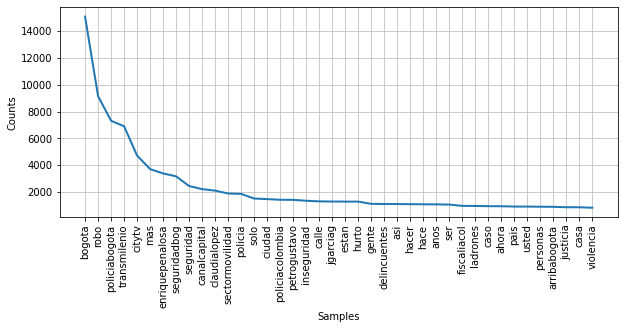

In [4]:
def proc_string(strin,setData):
    resp = set([]);
    for data in tok_cln(proc_str(strin)):
        tm  = stemm_data(data)
        #tm = data
        resp.add(tm)
        if tm in setData:
            setData[tm].add(data)
        else:
            setData[tm] = set([data])
    return ', '.join(resp);

def freq_dist_tok(strin):
    token_clear = strin.apply(tok_cln)
    out = [item for t in token_clear for item in t] 
    fig = plt.figure(figsize = (10,4))
    plt.gcf().subplots_adjust(bottom=0.15)
    fdist = FreqDist(out)
    fdist.plot(40,cumulative=False)
    return fig.savefig('freqDist.png', bbox_inches = "tight")

freq_dist_tok(data.Tweet);

In [5]:
def getVocab(fileName):
    positive_vocab = [];    
    negative_vocab = [];    
    xmldoc = minidom.parse(fileName)
    itemlist = xmldoc.getElementsByTagName('senticon')
    for s in itemlist[0].getElementsByTagName('layer'):    
        for pl in s.getElementsByTagName('positive'):
            for pll in pl.getElementsByTagName('lemma'):                
                positive_vocab.append([pll.firstChild.nodeValue.replace(" ", ""),
                                       float(pll.getAttribute('pol'))]);
        for pl in s.getElementsByTagName('negative'):
            for pll in pl.getElementsByTagName('lemma'):             
                negative_vocab.append([pll.firstChild.nodeValue.replace(" ", ""),
                                       float(pll.getAttribute('pol'))]);
    return (positive_vocab,negative_vocab)

In [6]:
(positive_vocab,negative_vocab) = getVocab('senticon.es.xml')

In [7]:
##Cuenta las ocurrencias de las palabras negativas y positivas
def getScoreSentiment(words,posText,posScore,negText,negScore,optionScore):  
    countTotalScore = 0;        
    for word in words:                        
        if len(word)>0:
            indicesPos = [i for i, x in enumerate(posText) if word in x.split('_')]
            indicesNeg = [i for i, x in enumerate(negText) if word in x.split('_')]
            cvalP = 0;
            for j in indicesPos:
                if optionScore==0:                
                    cvalP += 1;
                if optionScore==1:
                    cvalP += posScore[j];
                                    
            cvalN = 0;
            for k in indicesNeg:                 
                if optionScore==0:
                    cvalN -= 1;
                if optionScore==1:
                    cvalN += negScore[k];
                    
            if (len(indicesNeg)+len(indicesPos))>0:
                countTotalScore+=(cvalP+cvalN)/(len(indicesNeg)+len(indicesPos))
            
            finalval=(countTotalScore-1)/4
            if finalval>1.0:
                finalval=1.0
            if finalval<-1.0:
                finalval = -1.0
            finalval= (finalval*2)+3
            finalval = int(round(finalval))
    return (finalval)

def computeSentimentScoresDictionary(strWords,posText,posScore,negText,negScore,optionScore):
    vecScoreSentimentDictionary = [];
    for idx in strWords:        
        scv = getScoreSentiment(idx.split(' '),posText,posScore,negText,negScore,optionScore);
        vecScoreSentimentDictionary.append(scv)        
    df= pd.DataFrame({'Terms':strWords, 'Sentiment Score':vecScoreSentimentDictionary});    
    return (vecScoreSentimentDictionary,df);

In [8]:
posText = [row[0] for row in positive_vocab]
posScore = [row[1] for row in positive_vocab]
negText = [row[0] for row in negative_vocab]
negScore = [row[1] for row in negative_vocab]
vecScoreSentimentSimple = []
vecScoreSentimentPolarity = []





In [9]:
dfpp = data[data['Sentiment'].isin(['1','2','3','4','5'])]
for idx in dfpp.index:
    wordsOpinion = [];
    for data in tok_cln(dfpp['Tweet'][idx]):
        tm = data
        wordsOpinion.append(tm) 
    vecScoreSentimentSimple.append(getScoreSentiment(wordsOpinion,posText,
                                                     posScore,negText,negScore,0))        
    vecScoreSentimentPolarity.append(getScoreSentiment(wordsOpinion,posText,posScore,negText,negScore,1))
    

In [10]:
result = zip(dfpp.index,vecScoreSentimentSimple,vecScoreSentimentPolarity)
import csv
with open('lexicon.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(["ID","SentimentSimple","SentimentPolarity"])
    writer.writerows(result)  

In [11]:
datas=pd.read_csv("ScoreTotalData.csv")
results = pd.read_csv("lexicon.csv")
results = results.dropna(axis=1)
merged = datas.merge(results, on='ID')
merged.to_csv("final_lexicon.csv", index=False)

In [12]:
def get_metrics(true_labels, predicted_labels,clasificador):
    print(clasificador+' Accuracy:', 
          np.round(metrics.accuracy_score(true_labels, predicted_labels),4))
    print(clasificador+' Precision:', 
          np.round(metrics.precision_score(true_labels, 
                                           predicted_labels,average='weighted',zero_division=1),4))
    print(clasificador+' Recall:', 
          np.round(metrics.recall_score(true_labels, predicted_labels,average='weighted'),4))
    print(clasificador+' F1 score:', 
          np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'),4))
    print('\n')

In [13]:
lexi=pd.read_csv("final_lexicon.csv")
lexi.head()

,ID,Date,Time,Tweet,GoogleSentiment,Sentiment,SentimentSimple,SentimentPolarity
0,1,18/03/2019,17:20:23,Hemos impulsado la marcación de bicicletas com...,"0,366633743047714",4,3,3
1,2,18/03/2019,17:20:23,#BOGOTÁ - Desarticulada banda dedicada al hurt...,"0,396044045686722",4,1,2
2,3,18/03/2019,17:20:23,#SondeoADNdeHoy ¿Alguna vez ha sido víctima de...,"0,0512369275093079",3,3,3
3,4,18/03/2019,17:20:23,Estas son las víctimas detrás de un bicicleta ...,"0,179279953241348",3,2,2
4,5,18/03/2019,17:20:23,@NoticiasRCN En lo que va de 2019 se han denun...,"0,502632915973663",3,3,3


In [14]:
get_metrics(lexi.Sentiment, lexi.SentimentSimple,"Simple")

Simple Accuracy: 0.3815
Simple Precision: 0.3987
Simple Recall: 0.3815
Simple F1 score: 0.3835




In [15]:
get_metrics(lexi.Sentiment, lexi.SentimentPolarity,"Polarity")

Polarity Accuracy: 0.4174
Polarity Precision: 0.4463
Polarity Recall: 0.4174
Polarity F1 score: 0.3592


